# toad Tutorial 

Toad is a Python toolkit for professional model developers - a part of its functionality is specific for scorecard development. The toad package is countiously being upgraded and added for new features. We will introduce the key functionality in this tutorial, including:

1. EDA-related functions 
2. how to use toad to fine tune feature binning and conduct feature selection
3. WOE transformation 
4. stepwise feature selection 
5. model evaluation and validation
6. scorecard transformation 
7. other functions

-----------------
-----------------

### This tutorial will demonstrate how to use toad to model data of high dimension with efficiency. 

***Install and upgrade：***
1. pip：!pip install toad
2. conda：conda install toad --channel conda-forge
3. update：!pip install -U toad; conda install -U toad --channel conda-forge

***Feel free to open new issues on our [github](https://github.com/amphibian-dev/toad)***



In [4]:
import pandas as pd
import numpy as np
import toad

In [1]:
'''
Please upgrade to the latest version
'''

'\nPlease upgrade to the latest version\n'

-----------------------
### <font color='blue'>### 0. Load data</font>

The demo data has 165 dimensions, including one ID column, a target variable, and a month column. The feature columns contain both categorical and numerical features, with several having missing data. 

***This demo will showcase how toad can efficiently and effectively help model development for such dirty / nasty dataset.  ***


In [7]:
data = pd.read_csv('train.csv')
print('Shape:',data.shape)
data.head(10)

Shape: (108940, 167)


,APP_ID_C,target,var_d1,var_d2,var_d3,var_d4,var_d5,var_d6,var_d7,var_d8,...,var_l_118,var_l_119,var_l_120,var_l_121,var_l_122,var_l_123,var_l_124,var_l_125,var_l_126,month
0,app_1,0,Hit-6+ Vintage,816.0,RESIDENT INDIAN,Post-Graduate,M,RESIDENT INDIAN,SELF-EMPLOYED,Y,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
1,app_2,0,NaN,841.0,RESIDENT INDIAN,Post-Graduate,F,RESIDENT INDIAN,SALARIED,N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
2,app_3,0,Hit-6+ Vintage,791.0,RESIDENT INDIAN,Post-Graduate,M,RESIDENT INDIAN,PROPRIETOR,Y,...,0.0,0.088235,0.0,0.100000,0.0,0.011494,0.5,0.000000,0.0,2019-03
3,app_4,0,Hit-6+ Vintage,821.0,RESIDENT INDIAN,Graduate,M,RESIDENT INDIAN,SELF-EMPLOYED,N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
4,app_5,0,Hit-6+ Vintage,807.0,RESIDENT INDIAN,Graduate,M,RESIDENT INDIAN,SALARIED,Y,...,0.0,0.000000,0.0,0.000000,0.0,0.540541,0.0,0.285714,0.0,2019-03
5,app_6,0,Hit-6+ Vintage,788.0,RESIDENT INDIAN,Others,M,RESIDENT INDIAN,SALARIED,N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
6,app_7,0,Hit-6+ Vintage,779.0,RESIDENT INDIAN,Graduate,M,RESIDENT INDIAN,ATTORNEY AT LAW,Y,...,0.0,0.722222,0.0,0.777778,0.0,0.380952,0.0,0.571429,0.0,2019-03
7,app_8,0,Hit-6+ Vintage,801.0,RESIDENT INDIAN,Post-Graduate,M,RESIDENT INDIAN,SAL(RETIRAL AGE 60),N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
8,app_9,0,Hit-6+ Vintage,815.0,RESIDENT INDIAN,Graduate,F,RESIDENT INDIAN,NaN,Y,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
9,app_10,0,NaN,804.0,RESIDENT INDIAN,Graduate,M,RESIDENT INDIAN,PROPRIETOR,N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03


#### The dataset contains monthly data from Mar, 2019 - Jul, 2019. We will use Mar and Apr data as training sample and May, Jun, Jul data as out-of-time (OOT) sample.

In [4]:
print('month:',data.month.unique())

month: ['2019-03' '2019-04' '2019-05' '2019-06' '2019-07']


In [8]:
train = data.loc[data.month.isin(['2019-03','2019-04'])==True,:]
OOT = data.loc[data.month.isin(['2019-03','2019-04'])==False,:]

print('train size:',train.shape,'\nOOT size:',OOT.shape)

train size: (43576, 167) 
OOT size: (65364, 167)


-----------------------
### <font color='blue'>### I. EDA functions</font>

#### 1. toad.detect(dataframe): 

To EDA data statics and other information. The columns output the statistical summary of each column. The ones that should be paid attention with are: no. of missing, no. of unqiue values, mean for numerical features, mode for categorical features, etc. As per the cell below, the takeaway should include:

a. postive samples account for 2.2%: the mean of traget col is 0.0219479

b. several features have different amount of missing values: notice the missing col.

c. there are both categoical and numerical features. The unique values of several categorical features are high - from 10 to even 84: notice the unqiue col for features of type==object.

In [6]:
toad.detect(train)[:10]

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
APP_ID_C,object,43576,0.00%,43576,app_36227:0.00%,app_29819:0.00%,app_35476:0.00%,app_10104:0.00%,app_35794:0.00%,app_25789:0.00%,app_36858:0.00%,app_12750:0.00%,app_24:0.00%,app_13004:0.00%
target,int64,43576,0.00%,2,0.0213191,0.144447,0,0,0,0,0,0,1,1
var_d1,object,43576,37.57%,2,Hit-6+ Vintage:60.32%,Hit-lt 6 Vinta:2.10%,None,None,None,None,None,None,Hit-6+ Vintage:60.32%,Hit-lt 6 Vinta:2.10%
var_d2,float64,43576,5.44%,389,570.492,355.565,-1,-1,-1,778,810,832,864,900
var_d3,object,43576,5.31%,6,RESIDENT INDIAN:94.00%,NON-RESIDENT INDIAN:0.64%,PARTNERSHIP FIRM:0.02%,PRIVATE LTD COMPANIES:0.02%,PUBLIC LTD COMPANIES:0.00%,NON-RESIDENT INDIAN:0.64%,PARTNERSHIP FIRM:0.02%,PRIVATE LTD COMPANIES:0.02%,PUBLIC LTD COMPANIES:0.00%,OVERSEAS CITIZEN OF INDIA:0.00%
var_d4,object,43576,1.08%,5,Graduate:55.30%,Post-Graduate:21.57%,Others:10.71%,Under Graduate:10.67%,Professional:0.67%,Graduate:55.30%,Post-Graduate:21.57%,Others:10.71%,Under Graduate:10.67%,Professional:0.67%
var_d5,object,43576,1.08%,3,M:79.70%,F:14.33%,O:4.89%,None,None,None,None,M:79.70%,F:14.33%,O:4.89%
var_d6,object,43576,1.08%,13,RESIDENT INDIAN:93.34%,PRIVATE LTD COMPANIES:2.57%,PARTNERSHIP FIRM:1.45%,PUBLIC LTD COMPANIES:0.73%,NON-RESIDENT INDIAN:0.64%,CO-OPERATIVE SOCIETIES:0.01%,LIMITED LIABILITY PARTNERSHIP:0.00%,ASSOCIATION:0.00%,TRUST-NGO:0.00%,OVERSEAS CITIZEN OF INDIA:0.00%
var_d7,object,43576,1.60%,84,SALARIED:31.43%,PROPRIETOR:31.31%,SELF-EMPLOYED:10.74%,OTHERS:6.40%,FIRST TIME USERS:2.72%,NURSE:0.00%,PHARMACIST:0.00%,RETAIL BUS OPERATOR:0.00%,PRIVATE TAILOR:0.00%,TAXI DRIVER:0.00%
var_d8,object,43576,1.08%,2,Y:59.90%,N:39.03%,None,None,None,None,None,None,Y:59.90%,N:39.03%


#### 2. toad.quality(dataframe, target='target', iv_only=False):

Output IV (information value), gini, entropy and no. of unique values for each feature. The features are sorted by IV in a descending order. "target" is the target variable, and 'iv_only' specifies whether to calculate IV only. 


<font color='red'>Note: it is recommended to set "iv_only=True" for large dataset or high-dimensional data.  </font>

In [7]:
toad.quality(data,'target',iv_only=True)[:15]

,iv,gini,entropy,unique
var_b19,0.353043,NaN,NaN,88.0
var_b18,0.317603,NaN,NaN,46.0
var_d2,0.313443,NaN,NaN,411.0
var_d7,0.309985,NaN,NaN,95.0
var_b10,0.301111,NaN,NaN,15726.0
var_b17,0.240104,NaN,NaN,235.0
var_b16,0.231403,NaN,NaN,104.0
var_b24,0.226939,NaN,NaN,30928.0
var_b20,0.198655,NaN,NaN,34.0
var_b11,0.187306,NaN,NaN,239.0


-----------------------
### <font color='blue'>### II. how to use toad to fine tune feature binning and conduct feature selection</font>

#### 3. toad.selection.select(dataframe, target='target', empty=0.9, iv=0.02, corr=0.7, return_drop=False, exclude=None):

Conduct preliminary feature selection according to missing percentage, IV and correlation (with other features), the variables are:

(1) empyt=0.9: the features with missing percentage larger than 90% are filtered;

(2) iv=0.02: the features with IV smaller than 0.02 are eliminated;

(3) corr=0.7: if two or more features have Pearson correlation larger than 0.7, the ones with lower IV are eliminated;

(4) return_drop=False: if set True, the function returns a list of deleted columns;

(5) exclude=None: input the list of features to be excluded from the algorithm, typically ID column and month column. 

As shown in the cell below, none feautures are deleted due to high missing values, most values are deleted by the IV threshold, several are deleted for the correlation. In the end, 32 features are chosen from initially 165. 

In [9]:
train_selected, dropped = toad.selection.select(train,target = 'target', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True, exclude=['APP_ID_C','month'])
print(dropped)
print(train_selected.shape)

{'empty': array([], dtype=float64), 'iv': array(['var_d1', 'var_d4', 'var_d8', 'var_d9', 'var_b5', 'var_b6',
       'var_b7', 'var_l_1', 'var_l_2', 'var_l_3', 'var_l_4', 'var_l_5',
       'var_l_6', 'var_l_7', 'var_l_8', 'var_l_10', 'var_l_12',
       'var_l_14', 'var_l_15', 'var_l_16', 'var_l_17', 'var_l_18',
       'var_l_21', 'var_l_23', 'var_l_24', 'var_l_25', 'var_l_26',
       'var_l_27', 'var_l_28', 'var_l_29', 'var_l_30', 'var_l_31',
       'var_l_32', 'var_l_33', 'var_l_34', 'var_l_35', 'var_l_37',
       'var_l_38', 'var_l_39', 'var_l_40', 'var_l_41', 'var_l_42',
       'var_l_43', 'var_l_44', 'var_l_45', 'var_l_47', 'var_l_49',
       'var_l_51', 'var_l_53', 'var_l_55', 'var_l_56', 'var_l_57',
       'var_l_59', 'var_l_61', 'var_l_62', 'var_l_63', 'var_l_65',
       'var_l_67', 'var_l_70', 'var_l_72', 'var_l_75', 'var_l_76',
       'var_l_77', 'var_l_78', 'var_l_79', 'var_l_80', 'var_l_81',
       'var_l_82', 'var_l_83', 'var_l_84', 'var_l_85', 'var_l_86',
       'var_l_87',

#### 4. Fine binning

Toad's binning function support both categorical and numerical features. The class "toad.transform.Combiner()" is used to train, the procedure is below:

(1)  *** initalise: ***c = toad.transform.Combiner()

(2) ***train binning***: c.fit(dataframe, y = 'target', method = 'chi', min_samples = None, n_bins = None, empty_separate = False) 

    - y: target variable;

    - method: the method to apply binning. Suport 'chi' (Chi-squared), 'dt', (decisin tree), 'kmeans' (K-means), 'quantile' (by the same percentile), and 'step' (by the same step);

    - min_samples: can be a number or a porportion. Minimum number / porportion of samples required in each bucket;
    
    - n_bins: mininum number of buckets. If the number is too large, the algorithm will return the maxinum number of buckets it can get;

    - empty_separate: whether to seperate the missing values in a bucket. If False, missing values will be put along with the bucket of most close bad rate. 


(3) ***binning results***：c.export()

(4) ***adjust  bins***: c.set_rules(dict)

(5) ***apply bins and convert to discrete values***: c.transform(dataframe, labels=False):

    - labels: whether to convert data to explanatory labels. Returns 0, 1, 2 ... when False. Categorical features will be sorted in a descending order of  porportion. Returns (-inf, 0], (0,10], (10, inf) when True.
    
<font color='red'>Note: 1. remember to exclude the unwanted columns, especially ID column and timestamp column. 2. Columns with large number of unique values may take much time to train.</font>  

In [11]:
# initialise
c = toad.transform.Combiner()

to_drop=['APP_ID_C','month']
# Train binning with the selected features from previous; use reliable Chi-squared binning, and control that each bucket has at least 5% sample.
c.fit(train_selected, y = 'target', method = 'chi', min_samples = 0.05, exclude = to_drop) #empty_separate = False

# For the demonstration purpose, only showcase 3 bin results.
print('var_d2:',c.export()['var_d2'])
print('var_d5:',c.export()['var_d5'])
print('var_d6:',c.export()['var_d6'])

var_d2: [747.0, 782.0, 820.0]
var_d5: [['O', 'nan', 'F'], ['M']]
var_d6: [['PUBLIC LTD COMPANIES', 'NON-RESIDENT INDIAN', 'PRIVATE LTD COMPANIES', 'PARTNERSHIP FIRM', 'nan'], ['RESIDENT INDIAN', 'TRUST', 'TRUST-CLUBS/ASSN/SOC/SEC-25 CO.', 'HINDU UNDIVIDED FAMILY', 'CO-OPERATIVE SOCIETIES', 'LIMITED LIABILITY PARTNERSHIP', 'ASSOCIATION', 'OVERSEAS CITIZEN OF INDIA', 'TRUST-NGO']]


#### 5. Fine tune bins

The "toad.plot" provides functions for visualisation to help make adjustment.

(1) ***In-sample visualisation  ***： toad.plot.bin_plot(dataframe, x = None, target = 'target)

The bars are the proportion of each binned class, and the line is the corresponding postive sample proportion (e.g. bad rate).

    - x: the feature column of interest
    
    - target: target variable

No handles with labels found to put in legend.
No handles with labels found to put in legend.


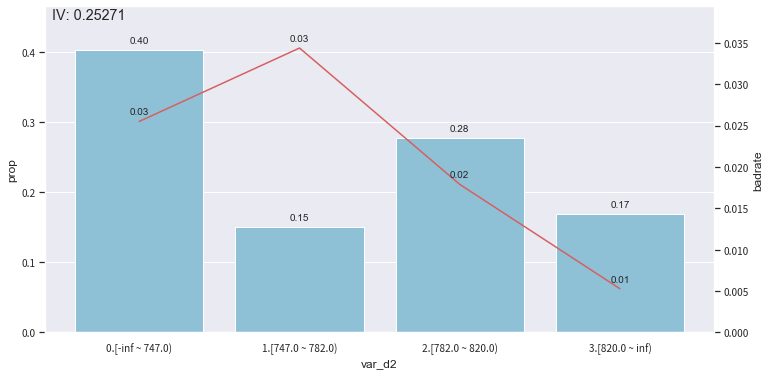

In [15]:
from toad.plot import bin_plot

# Check the bin results of 'var_d2' of in-sample 
col = 'var_d2'

# It's recommended to set 'labels = True' for better visualisation.
bin_plot(c.transform(train_selected[[col,'target']], labels=True), x=col, target='target')

(2) ***OOT visualisation：*** toad.plot.badrate_plot(dataframe, target = 'target', x = None, by = None)

Show the positive rates of each class across different time.

    - target: target variable
    
    - x: time column, must be in string
    
    - by: feature column of interest

<font color='red'>Note: the time column must be preprocessed and converted to string - timestamp is not supported</font> 

'\nA feature is preferrable if the gaps between classes get wider as time goes by - it means the binned classes have larger difference. No line crossing means the bin results are stable.\n'

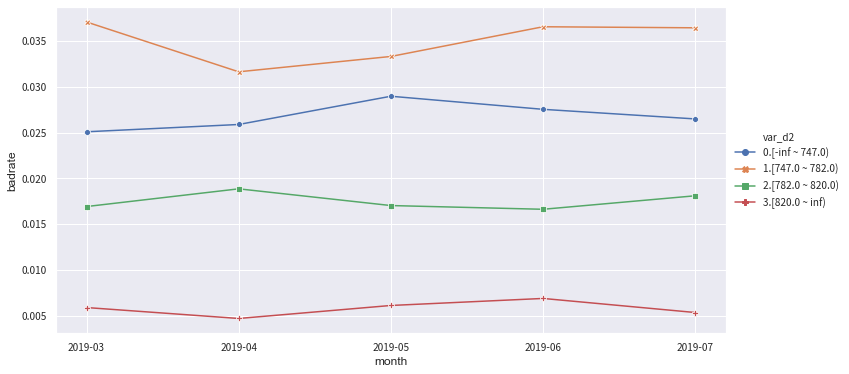

In [14]:
from toad.plot import badrate_plot

col = 'var_d2'

# Check the stability of 'var_d2''s bins across time
#badrate_plot(c.transform(train[[col,'target','month']], labels=True), target='target', x='month', by=col)
#badrate_plot(c.transform(OOT[[col,'target','month']], labels=True), target='target', x='month', by=col)

badrate_plot(c.transform(data[[col,'target','month']], labels=True), target='target', x='month', by=col)
'''
A feature is preferrable if the gaps between classes get wider as time goes by - it means the binned classes have larger difference. No line crossing means the bin results are stable.
'''

No handles with labels found to put in legend.
No handles with labels found to put in legend.


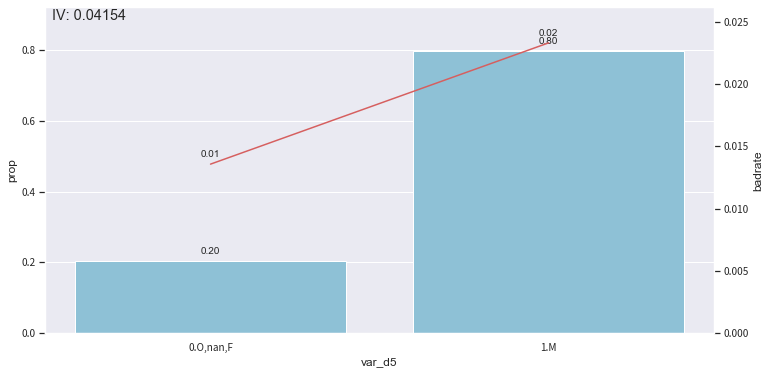

In [12]:
# Check the bin results of var_d5 of in-sample
col = 'var_d5'

# It's recommended to set 'labels = True' for categorical features.
bin_plot(c.transform(train_selected[[col,'target']], labels=True), x=col, target='target')

(3) ***adjust bins：***c.set_rules(dict)

the passed new bins will be updated - other feature bins are kept intact. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


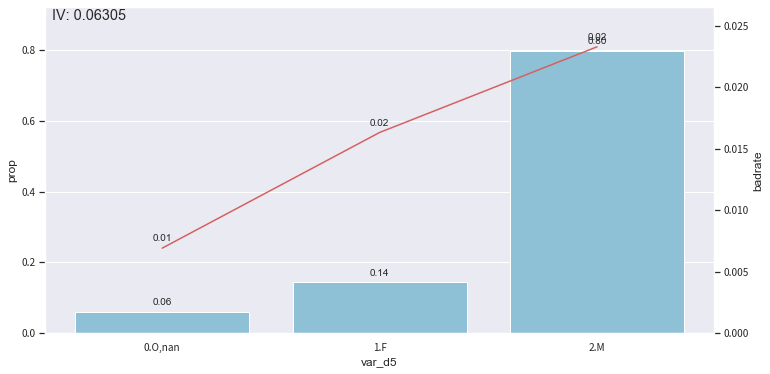

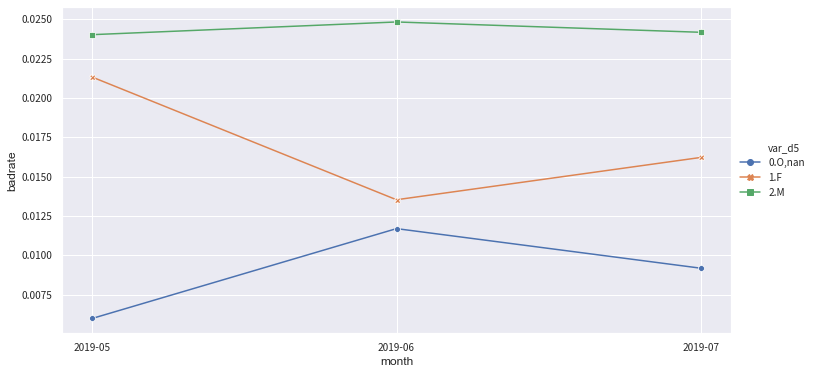

In [16]:
# The IV is small, assume we want to seperate 'F' out to lift IV. 

# Set new bins 
rule = {'var_d5':[['O', 'nan'],['F'], ['M']]}

# Pass new bins
c.set_rules(rule)

# Re-check both in-sample and OOT stability. 
bin_plot(c.transform(train_selected[['var_d5','target']], labels=True), x='var_d5', target='target')
badrate_plot(c.transform(OOT[['var_d5','target','month']], labels=True), target='target', x='month', by='var_d5')

### <font color='blue'>###  III. WOE transformation</font>

WOE transformation is applied after binning is tuned and finalised. The procedure is following:

(1) ***Use the finalised Combiner to apply the binning:*** c.transform(dataframe, labels=False) 

    It only transform the binned features. 

(2) ***initialise woe transer:*** transer =  toad.transform.WOETransformer()

(3) ***fit_transform:*** transer.fit_transform(dataframe, target, exclude = None)


    Fit and apply WOE transformation, for in-sample data
    
    - target：target values in Series or DataFrame;
    
    - exclude: columns not be WOE transformed
<font color='red'> Note: 1. "fit_transform" fits and transform all the data, even the ones not binned. Remember to exclude the unwanted columns. 2. Alwasy exlclude target column.</font>
    
(4)  ***Apply WOE transformation, typically to test / OOT data：***transer.transform(dataframe)

In [14]:
# Initialise
transer = toad.transform.WOETransformer()

# transer.fit_transform() & combiner.transform(). Remember to exclude target
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['target'], exclude=to_drop+['target'])
OOT_woe = transer.transform(c.transform(OOT))

print(train_woe.head(3))

  APP_ID_C  target    var_d2    var_d3    var_d5    var_d6    var_d7  \
0    app_1       0 -0.178286  0.046126  0.090613  0.047145  0.365305   
1    app_2       0 -1.410248  0.046126 -0.271655  0.047145 -0.734699   
2    app_3       0 -0.178286  0.046126  0.090613  0.047145  0.365305   

    var_d11    var_b3    var_b9  ...  var_l_60  var_l_64  var_l_68  var_l_71  \
0 -0.152228 -0.141182 -0.237656  ...  0.132170  0.080656  0.091919  0.150975   
1 -0.152228  0.199186  0.199186  ...  0.132170  0.080656  0.091919  0.150975   
2 -0.152228 -0.141182  0.388957  ... -0.926987 -0.235316 -0.883896 -0.385976   

   var_l_89  var_l_91  var_l_107  var_l_119  var_l_123    month  
0  0.091901  0.086402  -0.034434   0.027322   0.087378  2019-03  
1  0.091901  0.086402  -0.034434   0.027322   0.087378  2019-03  
2  0.091901 -0.620829  -0.034434  -0.806599  -0.731941  2019-03  

[3 rows x 34 columns]


### <font color='blue'>###  IV.Stepwise regression feature selection</font>
---------------

6. ***toad.selection.stepwise(dataframe, target='target', estimator='ols', direction='both', criterion='aic', max_iter=None, return_drop=False, exclude=None): ***

Stepwise regression feature selection, supports forward, backward, and both-direction (recommended):

    - estimator: the regression model to fit, support 'ols', 'lr', 'lasso', 'ridge' 
    
    - direction: stepwise direction, support 'forward', 'backward', 'both' (recommended)
    
    - criterion: selection criteria, support 'aic', 'bic', 'ks', 'auc'
    
    - max_iter: maximum number of iterations
    
    - return_drop: whether to return a list of dropped column names
    
    - exclude: list of column to be from alogorithm, such as ID column and time column.
    
***tip: generally, direction = 'both' produces the best results. Setting estimator =  'ols' and criterion = 'aic' makes the stepwise fast and the results are sound for logistic regression.***




In [15]:
# Apply stepwise regression on the WOE-transformed data
final_data = toad.selection.stepwise(train_woe,target = 'target', estimator='ols', direction = 'both', criterion = 'aic', exclude = to_drop)

#  Place the selected features to test / OOT sample 
final_OOT = OOT_woe[final_data.columns]

print(final_data.shape) #  Out of 31 features, stepwise regression selected 10 of them.

(43576, 13)


In [16]:
# The final list of features for modelling
col = list(final_data.drop(to_drop+['target'],axis=1).columns)

7. ***toad.metrics.PSI(df_train, df_test):***

Ouput the PSI for each feature - used to check the OOT stability of WOE-transformed features.

In [17]:
toad.metrics.PSI(final_data[col], final_OOT[col])

var_d2      0.000254
var_d5      0.000012
var_d7      0.000079
var_d11     0.000191
var_b10     0.000209
var_b18     0.000026
var_b19     0.000049
var_b23     0.000037
var_l_20    0.000115
var_l_68    0.000213
dtype: float64

### <font color='blue'>###  V. Model evaluation and validation</font>
---------------

7. **Common evaluation metrics**: toad. metrics. KS, F1, AUC

In [18]:
# Build a logit
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(final_data[col], final_data['target'])

# Obtain predicted probability for training and OOT 
pred_train = lr.predict_proba(final_data[col])[:,1]

pred_OOT_may =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-05',col])[:,1]
pred_OOT_june =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-06',col])[:,1]
pred_OOT_july =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-07',col])[:,1]

/Users/zhouxiyu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
from toad.metrics import KS, AUC

print('train KS',KS(pred_train, final_data['target']))
print('train AUC',AUC(pred_train, final_data['target']))
print('OOT results')
print('5月 KS',KS(pred_OOT_may, final_OOT.loc[final_OOT.month == '2019-05','target']))
print('6月 KS',KS(pred_OOT_june, final_OOT.loc[final_OOT.month == '2019-06','target']))
print('7月 KS',KS(pred_OOT_july, final_OOT.loc[final_OOT.month == '2019-07','target']))

train KS 0.3707986228750539
train AUC 0.75060723924743
OOT结果
5月 KS 0.3686687175756087
6月 KS 0.3495273403486497
7月 KS 0.3796914199845523


***PSI also be used to gauge the stability of predicted proabilities***

In [20]:
print(toad.metrics.PSI(pred_train,pred_OOT_may))
print(toad.metrics.PSI(pred_train,pred_OOT_june))
print(toad.metrics.PSI(pred_train,pred_OOT_june))

0.12760761722158315
0.1268648506657109
0.1268648506657109


8. ***toad.metrics.KS_bucket(predicted_proba, y_true, bucket=10, method = 'quantile'):***

output the evaluative information of binned predicted probability, including the probability range, no. of samples, bad rate, KS of each probability bin. 

    - bucket：no. of bins
    
    - method：method of binning. Recommend to use 'quantile' or 'step' 
    
<font color='red'> (1) the larger the difference of bad_rate between each group, the better the results; (2) can be used to check the monotonicity of groups of scores; (3) can be used to find the optimal cutoff point; (4) can be used to compare predictability of models </font>



In [21]:
# Group the predicted scores in bins with same number of samples in each (i.e. "quantile" binning)
toad.metrics.KS_bucket(pred_train, final_data['target'], bucket=10, method = 'quantile')

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,total_prop,cum_bads,cum_goods,cum_total,cum_bads_prop,cum_goods_prop,cum_total_prop,ks
0,0.000275,0.003380,9,4332,4341,0.002073,0.997927,0.002078,0.009688,0.101578,0.099619,9,4332,4341,0.009688,0.101578,0.099619,-0.091890
1,0.003398,0.005207,12,3585,3597,0.003336,0.996664,0.003347,0.012917,0.084062,0.082545,21,7917,7938,0.022605,0.185640,0.182164,-0.163035
2,0.005207,0.008116,37,5071,5108,0.007244,0.992756,0.007296,0.039828,0.118906,0.117220,58,12988,13046,0.062433,0.304547,0.299385,-0.242114
3,0.008125,0.010862,26,3854,3880,0.006701,0.993299,0.006746,0.027987,0.090370,0.089040,84,16842,16926,0.090420,0.394916,0.388425,-0.304497
4,0.010868,0.014651,59,4759,4818,0.012246,0.987754,0.012398,0.063509,0.111590,0.110565,143,21601,21744,0.153929,0.506507,0.498990,-0.352578
5,0.014661,0.019846,76,3901,3977,0.019110,0.980890,0.019482,0.081808,0.091472,0.091266,219,25502,25721,0.235737,0.597979,0.590256,-0.362241
6,0.019858,0.025968,116,4665,4781,0.024263,0.975737,0.024866,0.124865,0.109386,0.109716,335,30167,30502,0.360603,0.707365,0.699972,-0.346762
7,0.025986,0.032467,108,4188,4296,0.025140,0.974860,0.025788,0.116254,0.098202,0.098586,443,34355,34798,0.476857,0.805567,0.798559,-0.328710
8,0.032484,0.044998,173,4187,4360,0.039679,0.960321,0.041318,0.186222,0.098178,0.100055,616,38542,39158,0.663079,0.903745,0.898614,-0.240666
9,0.045115,0.370055,313,4105,4418,0.070847,0.929153,0.076248,0.336921,0.096255,0.101386,929,42647,43576,1.000000,1.000000,1.000000,0.000000


### <font color='blue'>###  VI. Standard scorecard transformation</font>
---------------

6. **toad.ScoreCard( combiner = {}, transer = None, pdo = 60, rate = 2, base_odds = 20, base_score = 750, card = None, C=0.1,**kwargs): 

Convert logit into a standard scorecard. Support direct input of parameters of a LogisticRegression class.

    - combiner: input the pre-fitted toad.Combiner class
    
    - transer: input the per-fitted toad.WOETransformer class
    
    - pdo、rate、base_odds、base_score: 
     e.g. pdo=60, rate=2, base_odds=20,base_score=750
          it means when odds is 1/60, the base socre is 750, and t
   
    - card: 支持传入专家评分卡 pre-defined scorecard
    
    - **kwargs: support to input parameters of a logistic regression class (i.e. sklearn.linear_model.LogisticRegression)
    

In [22]:
card = toad.ScoreCard(
    combiner = c,
    transer = transer,
    #class_weight = 'balanced',
    #C=0.1,
    #base_score = 600,
    #base_odds = 35 ,
    #pdo = 60,
    #rate = 2
)

card.fit(final_data[col], final_data['target'])

/Users/zhouxiyu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ScoreCard(base_odds=35, base_score=750, card=None,
          combiner=<toad.transform.Combiner object at 0x1a2434fdd8>, pdo=60,
          rate=2,
          transer=<toad.transform.WOETransformer object at 0x1a235a5358>)

In [23]:
# Output standard scorecard 
card.export()

{'var_d2': {'[-inf ~ 747.0)': 65.54,
  '[747.0 ~ 782.0)': 45.72,
  '[782.0 ~ 820.0)': 88.88,
  '[820.0 ~ inf)': 168.3},
 'var_d5': {'O,nan': 185.9, 'F': 103.26, 'M': 68.76},
 'var_d7': {'LARGE FLEET OPERATOR,COMPANY,STRATEGIC TRANSPRTER,SALARIED,HOUSEWIFE': 120.82,
  'DOCTOR-SELF EMPLOYED,nan,SAL(RETIRAL AGE 60),SERVICES,SAL(RETIRAL AGE 58),OTHERS,DOCTOR-SALARIED,AGENT,CONSULTANT,DIRECTOR,MEDIUM FLEETOPERATOR,TRADER,RETAIL TRANSPORTER,MANUFACTURING,FIRST TIME USERS,STUDENT,PENSIONER': 81.32,
  'PROPRIETOR,TRADING,STRATEGIC CAPTIVE,SELF-EMPLOYED,SERV-PRIVATE SECTOR,SMALL RD TRANS.OPR,BUSINESSMAN,CARETAKER,RETAIL,AGRICULTURIST,RETIRED PERSONNEL,MANAGER,CONTRACTOR,ACCOUNTANT,BANKS SERVICE,GOVERNMENT SERVICE,ADVISOR,STRATEGIC S1,SCHOOLS,TEACHER,GENARAL RETAILER,RESTAURANT KEEPER,OFFICER,POLICEMAN,SERV-PUBLIC SECTOR,BARRISTER,Salaried,SALESMAN,RETAIL CAPTIVE,Defence (NCO),STRATEGIC S2,OTHERS NOT DEFINED,JEWELLER,SECRETARY,SUP STRAT TRANSPORT,LECTURER,ATTORNEY AT LAW,TAILOR,TECHNICIAN,CLERK,

### <font color='blue'>###  VII. Other functions </font>

--------------------

***toad.transform.GBDTTransformer ***

 GBDT encoding - pre-processing for gbdt + lr technique. 

In [28]:
gbdt_transer = toad.transform.GBDTTransformer()
gbdt_transer.fit(final_data[col+['target']], 'target', n_estimators = 10, max_depth = 2)

/Users/zhouxiyu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [29]:
gbdt_vars = gbdt_transer.transform(final_data[col])

In [31]:
gbdt_vars.shape

(43576, 40)